In [453]:
import os
import pandas as pd
import numpy as np
import json
import warnings
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime
from zipline.utils.factory import load_bars_from_yahoo
import pytz
import talib
import numpy as np
from sklearn import model_selection
from sklearn import preprocessing
import matplotlib.pyplot as plt
import ystockquote

In [454]:
def MAE(predicted, test_label):
    if len(predicted.shape)==1:
        predicted=np.expand_dims(predicted,axis=1)
    return ((predicted-test_label)**2).mean()

In [431]:
def plot_MSE(parameters,keys,error,r_name = 'RidgeRegressor'):
        title = ','.join(keys)
        plt.title('MSE vs '+title)
        plt.plot(parameters, error)
        plt.xscale('log')
        plt.xlabel('Alpha')
        plt.ylabel('MSE')
        directory = './'+r_name+'/'
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig(directory + 'MSE'+ '.png')
        plt.close()

In [455]:
from inspect import getmembers, isfunction
import regressors25

functions_list = [o for o in getmembers(regressors25) if isfunction(o[1])]
regressor_dict= dict(functions_list)
print regressor_dict

{'elastic_reg': <function elastic_reg at 0x7facbd777230>, 'ridge_reg': <function ridge_reg at 0x7facbd777758>, 'linear_reg': <function linear_reg at 0x7facbdd919b0>, 'svm_reg': <function svm_reg at 0x7facbd8d3cf8>, 'randomForest_reg': <function randomForest_reg at 0x7facbd777398>, 'lasso_reg': <function lasso_reg at 0x7facbd777d70>, 'ann_reg': <function ann_reg at 0x7facbd777cf8>}


In [456]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
def fit_model(X, y,cv_iter,model_str,index=1):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    regressor,params= regressor_dict[regressor_dict.keys()[index]]()
    scoring_fnc = make_scorer(mean_squared_error)
    grid = GridSearchCV(regressor, params,scoring=scoring_fnc,cv=cv_iter)
    grid = grid.fit(X, y)
    return grid

In [434]:
def plot_prediction(price,dates_df,model_name,ticker,save=False):
    plt.title("Prediction for "+model_name+" Regressor")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.plot(price,label='Actual Price')
    plt.plot(dates_df, label='Predicted Price')
    plt.legend(loc='upper left')
    plt.xticks(rotation='vertical')
    plt.subplots_adjust(bottom=0.3)
    if save:
        directory = './Predictions/'+model_name+'/'
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig(directory+'prediction'+ticker+'.png')
    else:
        plt.show()
    plt.close()

In [435]:
from collections import deque
def get_last_cv(splits):
    dd = deque(splits, maxlen=1)
    last_element = dd.pop()
    train,test = last_element
    return train,test

In [436]:
def poly_transform(train,test,degree):
    poly = PolynomialFeatures(degree)
    train = poly.fit_transform(train)
    test = poly.fit_transform(test)
    return train,test

In [437]:
print regressor_dict.keys()

['elastic_reg', 'ridge_reg', 'linear_reg', 'svm_reg', 'randomForest_reg', 'lasso_reg', 'ann_reg']


In [451]:
from readData7 import getXY
X,Y = getXY(ticker)

readData7.py:43: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=30,center=False).mean()
  return pd.rolling_mean(df, N)[N - 1:].rename(columns={'Adj Close':'sma'+str(N)})
readData7.py:46: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,span=30,min_periods=0,adjust=True).mean()
  return pd.ewma(df, span=span).rename(columns={'Adj Close':'ema10'})
readData7.py:57: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=30,center=False).std()
  return 4*pd.stats.moments.rolling_std(data,length).rename(columns={'Adj Close':'bbw'})
readData7.py:60: FutureWarning: pd.rolling_max is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=2,center=False).max()
  high=pd.rolling_ma

[ 897.32781398  897.45481965  898.65550078  907.05064139  936.39561835
  966.55101633  972.93944073  950.77998702  877.67215551]


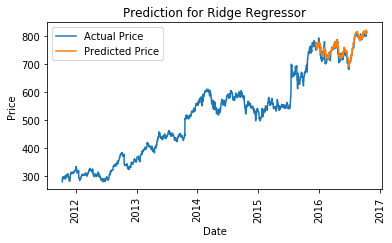

Adj Close    9.157761
dtype: float64
Adj Close    42.199921
dtype: float64
0.870603707487


In [452]:
from sklearn import linear_model
from sklearn.metrics import r2_score
import sklearn
import inspect
from sklearn.pipeline import Pipeline
check=[]
def f(n=30,n_spl=5,analyse_cv=True,poly_t=False):
    index = 1
    SEED = 100
    random_state = np.random.RandomState(SEED)
    tscv = TimeSeriesSplit(n_splits=n_spl)
    grid=fit_model(X.values,Y.values,tscv.split(X),'r',index)
    params = grid.best_params_ 
    reg ,_= regressor_dict[regressor_dict.keys()[index]]()
    reg.set_params(**params)
    model_name = type(reg).__name__
    if analyse_cv:
        print grid.cv_results_['mean_test_score']
        error =  grid.cv_results_['mean_test_score']
        grid_params =list(grid.cv_results_['params'])
        global check
        if len(grid_params[0].keys())>1:
            parameters = list(itertools.product(*grid_params.values()[::-1]))
        else:
            parameters =[f[grid_params[0].keys()[0]] for f in grid_params]
        plot_MSE(parameters,grid_params[0].keys(),error,model_name)
    else:
        tscv = TimeSeriesSplit(len(X)/n)
    train_index,test_index = get_last_cv(tscv.split(X))
    X_train ,X_test= X.iloc[train_index],X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    if poly_t:
        X_train,X_test = poly_transform(X_train,X_test,2)
    reg.fit(X_train,y_train)
    prediction = reg.predict(X_test)
    #print prediction.shape
    df = pd.Series(prediction.flatten(), index=y_test.index)
    price = y_train.append(y_test)
    plot_prediction(price,df,model_name,ticker)
    p_l = map(lambda x:[x],prediction)
    #print np.expand_dims(prediction, axis=0).shape
    if len(prediction.shape)==1:
        prediction=np.expand_dims(prediction,axis=1)
    print np.mean(abs(np.asarray(prediction)-y_test))
    print np.mean((np.asarray(prediction)-y_test))**2
    print reg.score(X_test,y_test)
    return reg
model =f(analyse_cv=True)